In [1]:
import sys
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
def create_dataloader(df):
    dl = TimeSeriesDataSet(
        df,
        time_idx="time_idx",
        target="Var_tc_readjusted",
        group_ids=["group_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["group_id", "Site_No"],
        static_reals=["tank_max_height", "tank_max_volume"],
        time_varying_known_categoricals=["Time_of_day"],
        time_varying_known_reals=["time_idx", "ClosingHeight_tc_readjusted" ,"ClosingStock_tc_readjusted", "TankTemp"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            "Var_tc_readjusted"
        ],
        target_normalizer=EncoderNormalizer(
            method='robust',
            max_length=None,
            center=True,
            transformation=None,
            method_kwargs={}
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True
    )
    return dl

In [76]:
train = pd.read_csv('../train_tl_AN.csv')
test_sequence = pd.read_csv('../test_tl_AN.csv')
path = os.getcwd() + '/15day_norm/trial_2/epoch=38.ckpt' #'/15day/trial_0/epoch=48.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)
tlgrouths = pd.read_csv('tankleakage_info.csv',index_col=0).reset_index(drop=True)
tank_sample_id = 'D143_5'
batch_size = 128
test_seq = test_sequence[(test_sequence['group_id'] == tank_sample_id)]
test_seq = test_seq[abs(test_seq['Var_tc_readjusted']) < 1]
test_seq = test_seq.reset_index(drop=True)
test_seq['time_idx'] = test_seq.index
max_prediction_length = 72
max_encoder_length = 5 * 2 * 24

C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [77]:
site_id = tank_sample_id[:4]
tank_id = tank_sample_id[-1]
tank_info = tlgrouths[(tlgrouths['Site'] == site_id) & (tlgrouths['Tank'] == int(tank_id))]
startdate = tank_info.iloc[0]['StartDate']
stopdate = tank_info.iloc[0]['StopDate']
temp_df = test_seq[test_seq['Time_DN'] > startdate]
startindex = temp_df.iloc[0]['time_idx']
op = startindex - max_encoder_length - 500
ed = startindex + max_prediction_length + 500

test = create_dataloader(test_seq)
test_data = TimeSeriesDataSet.from_dataset(test,  test_seq[lambda x: (x.time_idx < ed) & (x.time_idx >= op)], stop_randomization=True)
xs = test_seq[lambda x: (x.time_idx < ed) & (x.time_idx >= op)]['Time'].array
actual = test_seq[lambda x: (x.time_idx < ed) & (x.time_idx >= op)]['Var_tc_readjusted'].array
predictions = best_tft.predict(test_data, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
y_hat = []
for i in range(predictions.output["prediction"].data.shape[0]):
    y_hat.append(predictions.output["prediction"].data[i, 0, 3].numpy().min())
y_hat = y_hat + predictions.output["prediction"].data[-1, :, 3].numpy().tolist()[1:]
y_quantile = np.empty((len(xs[max_encoder_length:]), predictions.output["prediction"].data.shape[-1]))
for i in range(predictions.output["prediction"].data.shape[0]):
    y_quantile[i, :] = predictions.output["prediction"].data[i, 0, :].numpy()
y_quantile[-max_prediction_length+1:, :] = predictions.output["prediction"].data[-1, 1:, :].numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  wa

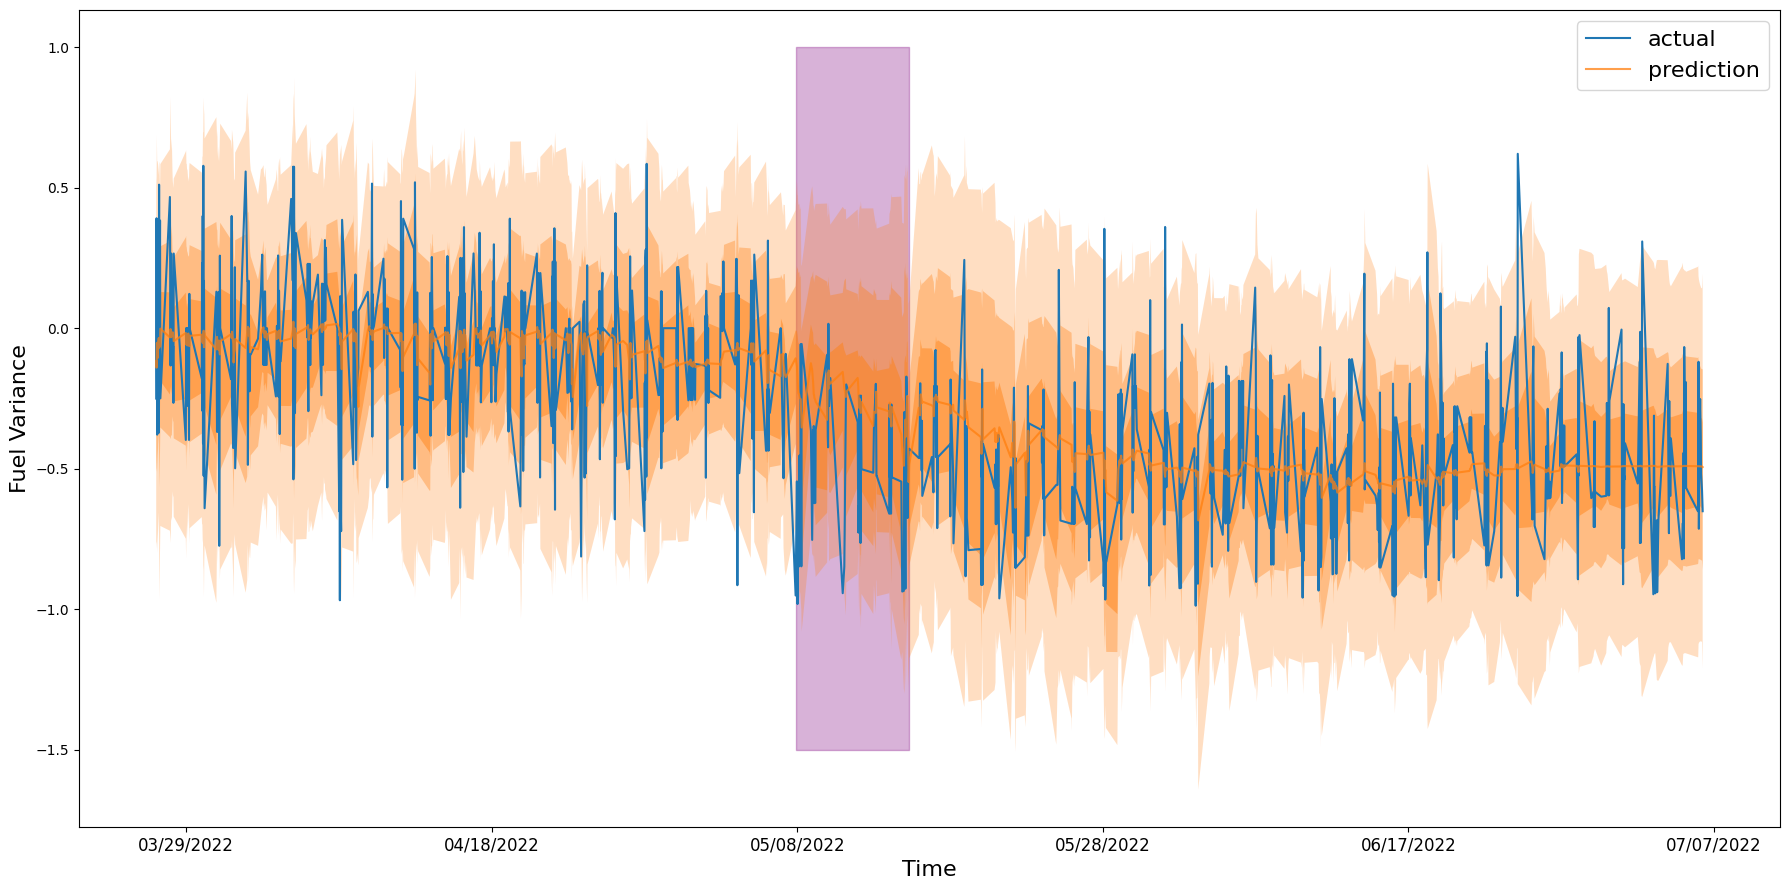

In [78]:
xs_plt = mdates.date2num(xs[max_encoder_length:])
fig, ax = plt.subplots(figsize=(18,9))
ax.plot(xs_plt, actual[max_encoder_length:], label="actual")
ax.plot(xs_plt, y_hat, label="prediction", alpha=0.75, color='C1')
ax.plot(xs_plt[500:500+max_prediction_length], y_hat[500:500+max_prediction_length], alpha=0.75, color='red')
for i in range(y_quantile.shape[1] // 2):
    ax.fill_between(xs_plt, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.25+i*0.1, fc='C1')
    ax.fill_between(xs_plt[500:500+max_prediction_length], y_quantile[500:500+max_prediction_length, i], y_quantile[500:500+max_prediction_length, -i - 1], color='red', alpha=0.25+i*0.1)

# ax.axvline(x=startindex, color='r', linestyle='--', label='ground truth')
ax.tick_params(axis='x', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.legend(fontsize=16)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Fuel Variance", fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('TFT_case.png')

In [58]:
op1 = startindex - max_encoder_length 
ed1 = startindex + max_prediction_length 
test_data = TimeSeriesDataSet.from_dataset(test,  test_seq[lambda x: (x.time_idx < ed1) & (x.time_idx >= op1)], stop_randomization=True)
xs = test_seq[lambda x: (x.time_idx < ed1) & (x.time_idx >= op1)]['Time'].array
actual = test_seq[lambda x: (x.time_idx < ed1) & (x.time_idx >= op1)]['Var_tc_readjusted'].array
predictions = best_tft.predict(test_data, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  wa

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

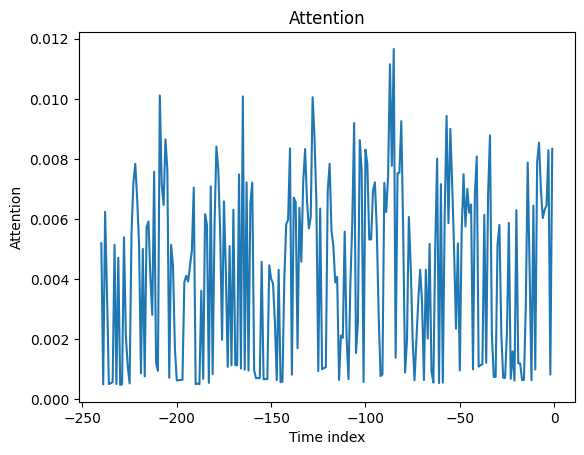

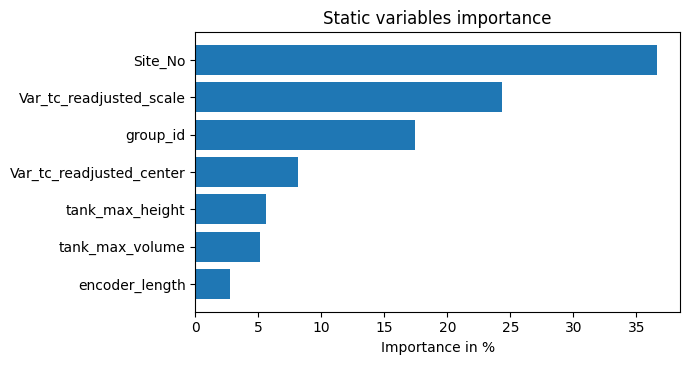

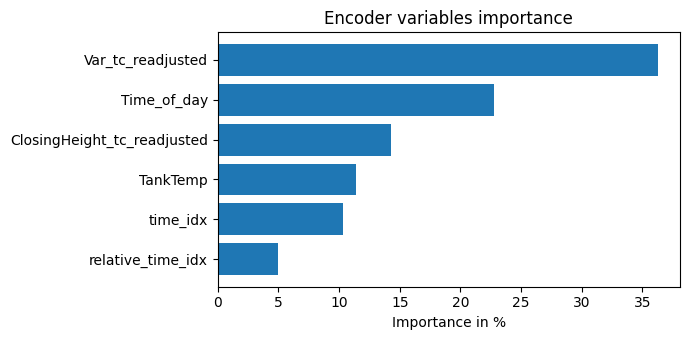

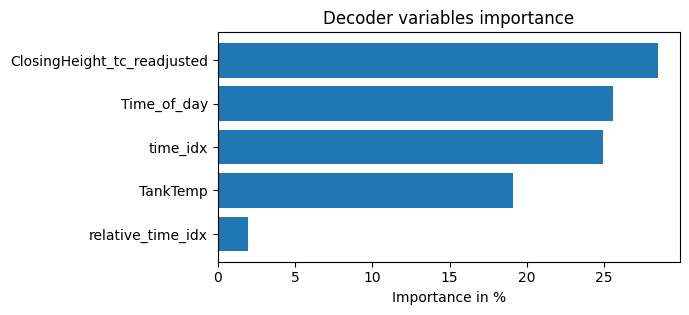

In [59]:
interpretation = best_tft.interpret_output(predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)